In [4]:
# Instalar bibliotecas 
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn joblib

In [5]:
import json
import numpy as np
import pandas as pd

# Caminhos dos arquivos (ajuste ao seu ambiente)
caminho_json = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\cejusc_14052025\dados_processos_cejusc_14052025_V1_enriquecidos.json"
caminho_embeddings = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\Embeddings\dados_processos_cejusc_14052025_V1_enriquecidos_Embeddings.npy"

# Carregar JSON enriquecido
with open(caminho_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

df = pd.DataFrame(dados)

# Carregar embeddings
vetores_texto = np.load(caminho_embeddings)

# Garantir que o DataFrame tenha o mesmo número de linhas que os embeddings
df = df.iloc[:vetores_texto.shape[0]]

print(f"DataFrame: {df.shape}")
print(f"Embeddings: {vetores_texto.shape}")

DataFrame: (11053, 39)
Embeddings: (11053, 3072)


In [6]:
# Seleção por prefixos
prefixos = ("tem_", "n_", "tipo_", "cita_", "pede_", "houve_", "tentou_", "usa_", "problema_", "citou_")
colunas_struct = [col for col in df.columns if col.startswith(prefixos)]

# Variáveis categóricas viram dummies
cat_cols = [col for col in colunas_struct if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Atualizar features finais após get_dummies
colunas_struct_final = [col for col in df.columns if col.startswith(prefixos)]
X_struct = df[colunas_struct_final].fillna(0).astype(float).values

In [7]:
# Combinar os vetores semânticos com os estruturados
X = np.hstack((vetores_texto, X_struct))

# Alvo: 1 = frutífero, 0 = infrutífero
y = df["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

print(f"X shape: {X.shape} | y shape: {y.shape}")

X shape: (11053, 3092) | y shape: (11053,)


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
)

# Split com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Instanciar o modelo
modelo = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
)

# Treinamento
modelo.fit(X_train, y_train)

# Predição
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

# Avaliação
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("MCC:", matthews_corrcoef(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66      1247
           1       0.53      0.42      0.47       964

    accuracy                           0.59      2211
   macro avg       0.57      0.57      0.56      2211
weighted avg       0.58      0.59      0.58      2211

Accuracy: 0.5852555404794211
F1: 0.46902142443543715
AUC: 0.592074505784838
MCC: 0.13876905618915159


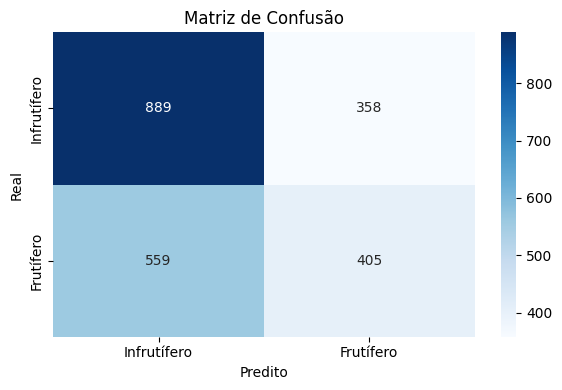

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Infrutífero", "Frutífero"],
            yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(modelo, X, y, cv=5, scoring='f1')
print("F1 médio (5-fold):", cv_scores.mean())

F1 médio (5-fold): 0.443639806744888


In [13]:
import joblib
joblib.dump(modelo, r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\Notebooks\XGBoost\modelo_classificacao_xgb.pkl")
print("Modelo salvo em 'modelo_classificacao_xgb.pkl'")

Modelo salvo em 'modelo_classificacao_xgb.pkl'
